## Final project notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import cmocean.cm as cmo
from scipy.interpolate import griddata
import glidertools as gt
from SJ_tools import final_proj_functions as fpf

/var/folders/9q/f1tj90w176qgctk31mz60mcw0000gn/T/ipykernel_2389/1227545313.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Jellyfish abundance data: timeseries and relative abundance

In [2]:
file_path = '/Users/sarah/Documents/MLML/Current_classes/MS263-Data_Analysis/Final_project/data/jelly_abundance_combined.csv'
jelly_ab = pd.read_csv(file_path,header=1)

In [3]:
jelly_ab

,year,abundance,species_group
0,1990,0.247798,Chrysaora
1,1991,0.282914,Chrysaora
2,1992,1.382158,Chrysaora
3,1993,0.531131,Chrysaora
4,1994,0.468061,Chrysaora
...,...,...,...
64,2011,3.901225,Aequorea
65,2012,7.649971,Aequorea
66,2013,3.498627,Aequorea
67,2014,6.548705,Aequorea


Subset the data by genus

In [4]:
chrysaora = jelly_ab[(jelly_ab['species_group'] == 'Chrysaora')]
aurelia = jelly_ab[(jelly_ab['species_group'] == 'Aurelia')]
aequorea = jelly_ab[(jelly_ab['species_group'] == 'Aequorea')]

Compute trend lines for timeseries of each genus

In [5]:
#chrysaora trend line
p = np.polyfit(chrysaora['year'], chrysaora['abundance'], 1)
slope = p[0]
intercept = p[1]
chry_bestfit = slope * chrysaora['year'] + intercept
# chry_bestfit
print(slope)

0.3152866847620536


In [6]:
# aequorea trend line
aq_p = np.polyfit(aequorea['year'], aequorea['abundance'], 1)
aq_slope = aq_p[0]
aq_intercept = aq_p[1]
aequo_bestfit = aq_slope * aequorea['year'] + aq_intercept
print(aq_slope)

-0.020589682166662796


In [7]:
# aurelia trend line
aur_p = np.polyfit(aurelia['year'], aurelia['abundance'], 1)
aur_slope = aur_p[0]
aur_intercept = aur_p[1]
aurelia_bestfit = aur_slope * aurelia['year'] + aur_intercept
print(aur_slope)

0.000182606998290419


Plot the timeseries with trend lines.

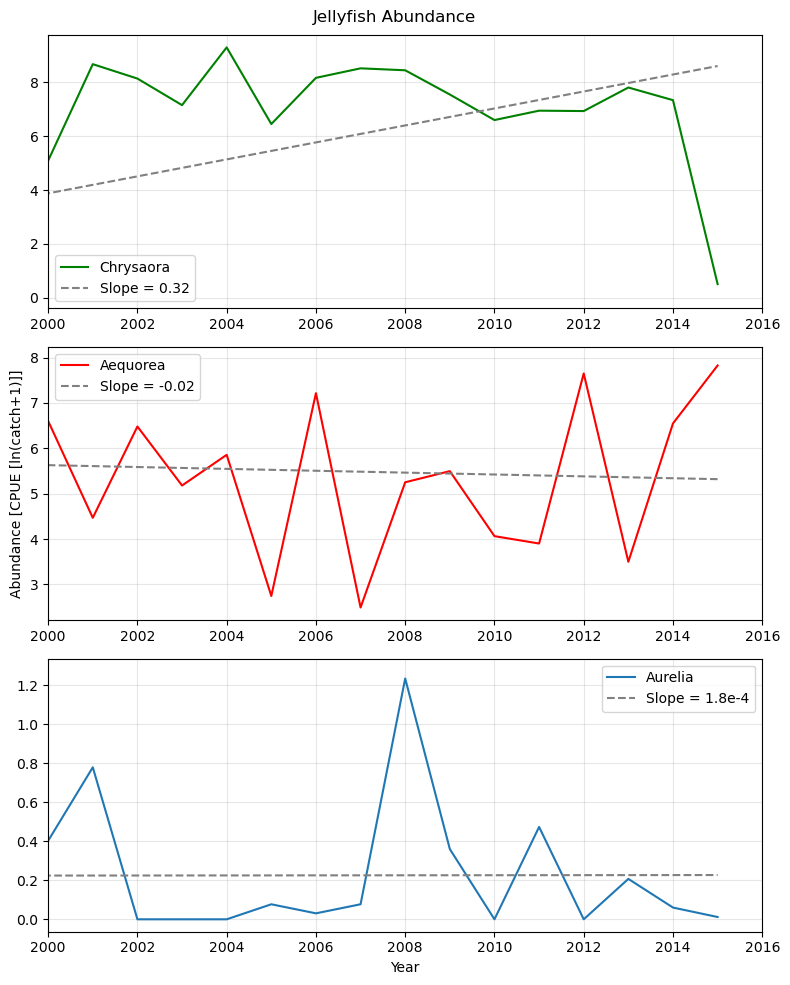

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

axes[0].plot(chrysaora['year'], chrysaora['abundance'], 'g', label='Chrysaora')
axes[0].plot(chrysaora['year'], chry_bestfit, 'grey', linestyle='--', label='Slope = 0.32')
axes[0].set_xlim([2000, 2016])
axes[1].plot(aequorea['year'], aequorea['abundance'], 'r', label='Aequorea')
axes[1].plot(aequorea['year'], aequo_bestfit, 'grey', linestyle='--', label='Slope = -0.02')
axes[1].set_xlim([2000, 2016])
axes[2].plot(aurelia['year'], aurelia['abundance'], label='Aurelia')
axes[2].plot(aurelia['year'], aurelia_bestfit, 'grey', linestyle='--', label='Slope = 1.8e-4')
axes[2].set_xlim([2000, 2016])

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].grid(alpha=0.3)
axes[1].grid(alpha=0.3)
axes[2].grid(alpha=0.3)

fig.suptitle('Jellyfish Abundance')
plt.xlabel('Year')
axes[1].set_ylabel('Abundance [CPUE [ln(catch+1)]]')

plt.tight_layout()
plt.show()

Calculate genus relative abundance

In [10]:
richness = 3
N = np.sum(jelly_ab['abundance']) #total biomass of all 3 genera
ni_chry = np.sum(chrysaora['abundance']) #total biomass of target genus
ni_aequo = np.sum(aequorea['abundance'])
ni_aurelia = np.sum(aurelia['abundance'])

In [11]:
chry_rel_ab = fpf.relative_abundance(richness, N, ni_chry)
aequo_rel_ab = fpf.relative_abundance(richness, N, ni_aequo)
aurelia_rel_ab = fpf.relative_abundance(richness, N, ni_aurelia)

In [12]:
print(chry_rel_ab)
print(aequo_rel_ab)
print(aurelia_rel_ab)

0.3286202145366619
0.3639372065898945
0.09619284658452551


In [13]:
genera = ['Chrysaora', 'Aequorea', 'Aurelia']
print(genera)

['Chrysaora', 'Aequorea', 'Aurelia']


In [14]:
relative_abundance = [chry_rel_ab, aequo_rel_ab, aurelia_rel_ab]
relative_abundance

[0.3286202145366619, 0.3639372065898945, 0.09619284658452551]

Plot relative abundances

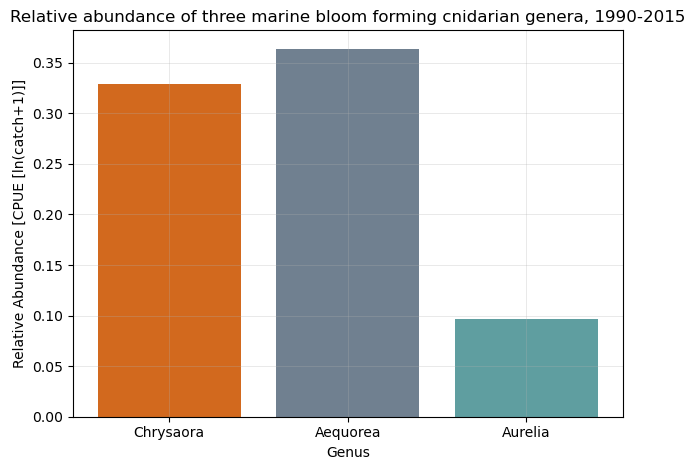

In [15]:
plt.figure()
plt.bar(genera, relative_abundance, color=['chocolate', 'slategray', 'cadetblue'])
plt.ylabel('Relative Abundance [CPUE [ln(catch+1)]]')
plt.xlabel('Genus')
plt.title('Relative abundance of three marine bloom forming cnidarian genera, 1990-2015')
plt.grid(linewidth=0.5, alpha=0.4)
plt.tight_layout()

### ANOVA to identify differences in overall abundance of the three genera

In [16]:
anova, post_hoc = fpf.jelly_anova(chrysaora, aurelia, aequorea)

In [17]:
anova

,Source,ddof1,ddof2,F,p-unc,np2
0,species_group,2,27.079618,91.449171,9.034781e-13,0.505113


In [18]:
post_hoc

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Aequorea,Aurelia,5.484606,0.224583,5.260023,0.430010,12.232318,16.890060,2.357635e-09,4.576846
1,Aequorea,Chrysaora,5.484606,4.666384,0.818222,0.815242,1.003656,38.677962,5.790404e-01,0.269557
2,Aurelia,Chrysaora,0.224583,4.666384,-4.441801,0.699767,-6.347539,25.513898,3.222228e-06,-1.733951


-- insert interpretation --

### Chlorophyll

In [23]:
file_pathc = '/Users/sarah/Documents/MLML/Current_classes/MS263-Data_Analysis/Final_project/data/Chl_yearly_data.csv'
chl_df = pd.read_csv(file_pathc,header=1)
chl_df

,year,chl-a con ave
0,2002,0.386018
1,2003,0.562396
2,2004,0.740899
3,2005,0.864926
4,2006,0.647860
5,2007,0.689585
6,2008,0.518115
7,2009,0.467241
8,2010,0.503023
9,2011,0.512370


### SST

In [20]:
file_paths = '/Users/sarah/Documents/MLML/Current_classes/MS263-Data_Analysis/Final_project/data/SST_yearlydata.csv'
sst_df = pd.read_csv(file_paths,header=1)

In [21]:
sst_df

,year,SST ave
0,2002,13.577818
1,2003,13.463408
2,2004,13.226202
3,2005,13.368108
4,2006,13.674460
5,2007,12.964195
6,2008,12.778083
7,2009,13.046718
8,2010,13.118148
9,2011,13.101617


Compute trend lines for SST and chl-a time series

In [37]:
# chl-a
chl_p = np.polyfit(chl_df['year'], chl_df['chl-a con ave'], 1)
chl_slope = chl_p[0]
chl_intercept = chl_p[1]
chl_bestfit = chl_slope * chl_df['year'] + chl_intercept
print(chl_slope)

# sst
sst_p = np.polyfit(sst_df['year'], sst_df['SST ave'], 1)
sst_slope = sst_p[0]
sst_intercept = sst_p[1]
sst_bestfit = sst_slope * sst_df['year'] + sst_intercept
print(sst_slope)

-0.012010455154682699
0.06235285498131208


#### Plot the time series of yearly averages of SST and chl-a concentration

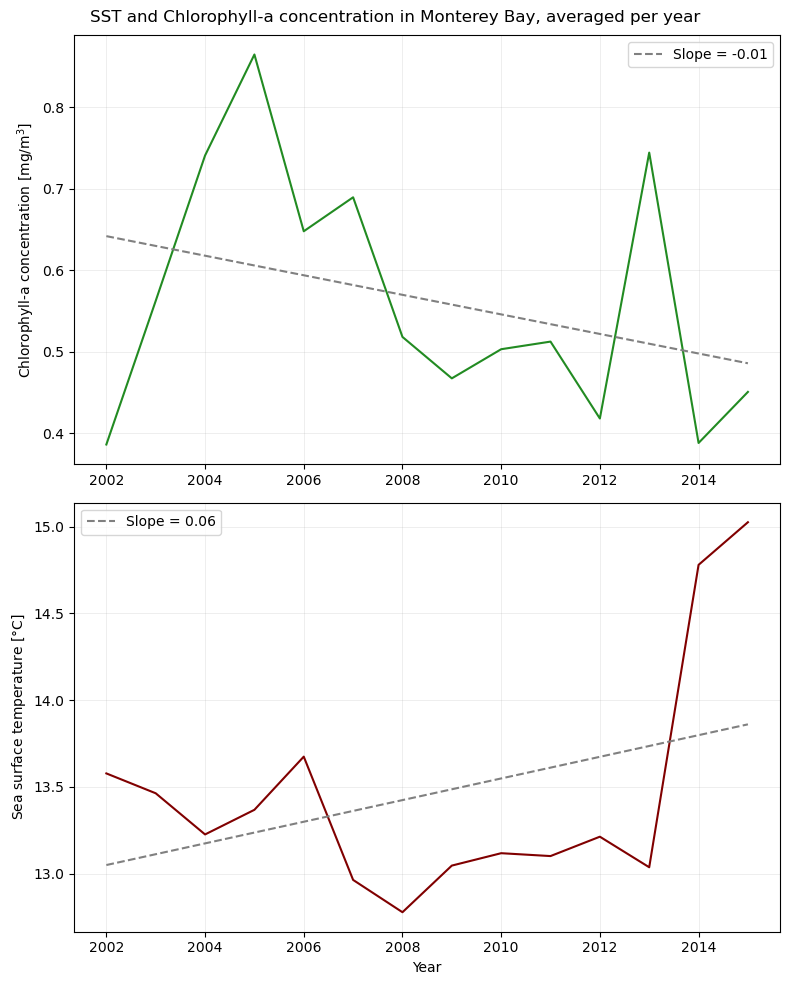

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
plt.suptitle('SST and Chlorophyll-a concentration in Monterey Bay, averaged per year')

axes[0].plot(chl_df['year'], chl_df['chl-a con ave'], 'forestgreen')
# plot the trend line
axes[0].plot(chl_df['year'], chl_bestfit, 'grey', linestyle='--', label='Slope = -0.01')
axes[0].set_ylabel('Chlorophyll-a concentration [mg/m$^3$]')
axes[0].grid(linewidth=0.5, alpha=0.3)
axes[0].legend(loc='best')
axes[1].plot(sst_df['year'], sst_df['SST ave'], 'maroon')
# plot the trend line
axes[1].plot(sst_df['year'], sst_bestfit, 'grey', linestyle='--', label='Slope = 0.06')
axes[1].set_ylabel('Sea surface temperature [$\degree$C]')
axes[1].grid(linewidth=0.5, alpha=0.3)
axes[1].set_xlabel('Year')
axes[1].legend(loc='best')

plt.tight_layout()

Merge data into one dataframe to do further analysis

only add jelly data from 2002 on (womp womp)

pd.merge?

if using sst and chl data from pre 2002, use different color/linestyle on the plot to show that data is from a diff satellite